# Install dependemcies

In [ ]:
#!pip install tensorflow-gpu==1.8.0 Keras==2.1.6 pydot
# !sudo apt-get install graphviz -y

# Imports

In [1]:
from keras.utils.vis_utils import model_to_dot
import pydot
from IPython.display import SVG
import json
import numpy as np

import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.utils import multi_gpu_model
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import os
import matplotlib.pyplot as plt


%matplotlib inline

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Setup

In [2]:
!ls data

dog_breed  downloaded  food  food-101.tar.gz


In [7]:
# DATASET_NAME = "dog_breed"
#DATASET_NAME = "leaf"
DATASET_NAME = "food"
#DATASET_NAME = "bird"
#DATASET_NAME = "fungus"

NUM_GPUS = 1
PATH = f"data/{DATASET_NAME}"
train_folder = f"data/{DATASET_NAME}/train"
valid_folder = f"data/{DATASET_NAME}/valid"

In [8]:
!ls data/{DATASET_NAME}

labels.csv  tmp  train	valid


In [9]:
IMAGE_SIZE=224 
BATCH_SIZE=64 # number of images seen by model at once

In [10]:
!ls data/{DATASET_NAME}/train/ | head

bruschetta
fried_calamari
hot_and_sour_soup
huevos_rancheros
red_velvet_cake
spaghetti_bolognese
spring_rolls
tacos
tuna_tartare
waffles


In [11]:
train_generator = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input
                                     ,rotation_range=45
                                     ,width_shift_range=0.2
                                     ,height_shift_range=0.2
                                     ,shear_range=0.2
                                     ,zoom_range=0.25
                                     ,horizontal_flip=True
                                     ,fill_mode='nearest'
                                  )

train_batches = train_generator.flow_from_directory(
    train_folder, target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE,shuffle=True, seed=13,class_mode='categorical')



valid_generator =  ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)


valid_batches = valid_generator.flow_from_directory(
    valid_folder, target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 9377 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [12]:
NUM_CLASSES = train_batches.num_classes

In [13]:
base_model = keras.applications.mobilenet.MobileNet()

In [14]:
?keras.applications.mobilenet.MobileNet()

In [15]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

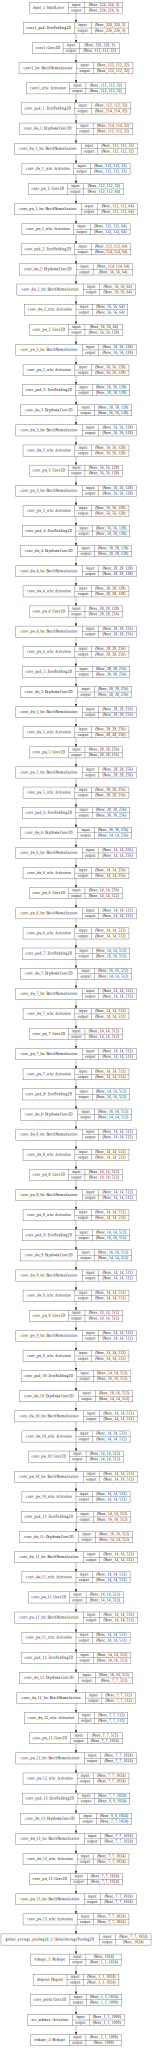

In [16]:
SVG(model_to_dot(base_model,show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [17]:
base_model.layers[-6].output

<tf.Tensor 'global_average_pooling2d_1/Mean:0' shape=(?, 1024) dtype=float32>

In [18]:
x = base_model.layers[-6].output
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

In [19]:
model = Model(inputs=base_model.input, outputs=predictions)


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [21]:
for layer in base_model.layers:
    layer.trainable = False

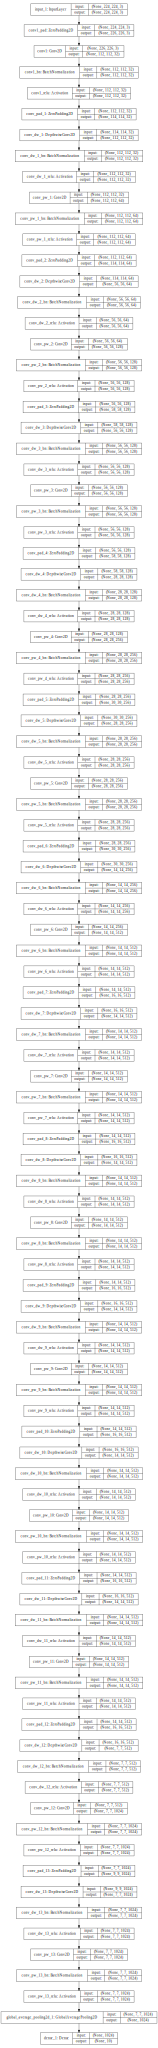

In [22]:
SVG(model_to_dot(model,show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [24]:
optimizer = RMSprop(lr=0.001, rho=0.9)

#optimizer = Adam(lr=0.001)

# model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#model.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
?multi_gpu_model

In [26]:
try:
    model = multi_gpu_model(model, gpus=NUM_GPUS)
except:
    pass
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
steps_per_epoch = train_batches.n//BATCH_SIZE
validation_steps =valid_batches.n // BATCH_SIZE

# steps_per_epoch = 10
# validation_steps = 3

In [28]:
!rm -rf logs

In [29]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1)

tb = keras.callbacks.TensorBoard(log_dir=f'{PATH}/logs', write_graph=True, write_images=True)


In [30]:
model.fit_generator(train_batches, steps_per_epoch=steps_per_epoch 
                    , validation_data=valid_batches
                    ,  validation_steps=validation_steps, verbose=2,workers=4 
                    , use_multiprocessing=True
                    , epochs=3
                   # , callbacks = [tb]
                   # , callbacks = [reduce_lr, tb]
                   )

Epoch 1/3
 - 104s - loss: 1.4396 - acc: 0.5173 - val_loss: 1.1370 - val_acc: 0.6134
Epoch 2/3
 - 97s - loss: 0.9810 - acc: 0.6679 - val_loss: 1.1098 - val_acc: 0.6391
Epoch 3/3
 - 95s - loss: 0.8815 - acc: 0.7064 - val_loss: 0.9940 - val_acc: 0.6678


In [31]:
train_batches.class_indices.keys()

dict_keys(['bruschetta', 'fried_calamari', 'hot_and_sour_soup', 'huevos_rancheros', 'red_velvet_cake', 'spaghetti_bolognese', 'spring_rolls', 'tacos', 'tuna_tartare', 'waffles'])

In [32]:
train_batches.class_indices

{'bruschetta': 0,
 'fried_calamari': 1,
 'hot_and_sour_soup': 2,
 'huevos_rancheros': 3,
 'red_velvet_cake': 4,
 'spaghetti_bolognese': 5,
 'spring_rolls': 6,
 'tacos': 7,
 'tuna_tartare': 8,
 'waffles': 9}

In [33]:
MODEL_SAVE_DIR = f'model/{DATASET_NAME}'

In [34]:
!mkdir -p {MODEL_SAVE_DIR}

In [35]:
shutil.rmtree(MODEL_SAVE_DIR)
os.makedirs(MODEL_SAVE_DIR)

In [36]:
model.save(f'{MODEL_SAVE_DIR}/model.h5')

In [37]:
with open(f'{MODEL_SAVE_DIR}/labels.txt', 'w') as file_handler:
    for item in train_batches.class_indices.keys():
        file_handler.write("{}\n".format(item))

In [38]:
with open(f'{MODEL_SAVE_DIR}/labels.json', 'w') as outfile:
    json.dump(train_batches.class_indices, outfile)